# Notebook to create spectrum plot 
(with overlaid spectral fits)

### Download data and uncompress the files into this folder

https://drive.google.com/file/d/1zywc5zUpMSlYDrrdogPEaRd_RTr9U5J6/view?usp=sharing

In [1]:
import numpy as np
import scipy.constants as sc
from scipy.stats import rv_histogram
import json
import matplotlib.pyplot as plt
import matplotlib
import la_forge.core as co

%config InlineBackend.figure_format='retina'
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

### Plotting specifications

In [2]:
# 15yr plotting specs
plt.rcParams.update(plt.rcParamsDefault)
with open('../ng15_rcparams.json', 'rb') as fin:
    plt.rcParams.update(json.load(fin))
plt.rcParams['text.latex.preamble'] = (
    r'\usepackage{amsmath}'
    r'\usepackage{amsbsy}'
    r'\DeclareMathAlphabet{\mathcal}{OMS}{cmsy}{m}{n}'
)

In [3]:
datapath = './figure1_data/'

### Sampling frequencies

In [4]:
# Fluctuation frequencies in 15yr dataset
Tspan = 505861299.1401644
freqs = np.arange(1,31)/Tspan
print(freqs)

[1.97682646e-09 3.95365292e-09 5.93047937e-09 7.90730583e-09
 9.88413229e-09 1.18609587e-08 1.38377852e-08 1.58146117e-08
 1.77914381e-08 1.97682646e-08 2.17450910e-08 2.37219175e-08
 2.56987439e-08 2.76755704e-08 2.96523969e-08 3.16292233e-08
 3.36060498e-08 3.55828762e-08 3.75597027e-08 3.95365292e-08
 4.15133556e-08 4.34901821e-08 4.54670085e-08 4.74438350e-08
 4.94206614e-08 5.13974879e-08 5.33743144e-08 5.53511408e-08
 5.73279673e-08 5.93047937e-08]


### 3A free-spec

In [5]:
# free-spec MCMC chain
corepath = datapath + '30fCP_30fiRN_3A_freespec_chain.core'
freespec = co.Core(corepath=corepath)  # open the file

params = freespec.params  # access parameter names

# crn free spec param names
hd_rho_labels = [f'gw_hd_log10_rho_{ii}' for ii in range(30)]  

# accessing crn free spec rhos
hd_chain = freespec(hd_rho_labels)  # returns array of burn-in chain

print(hd_chain.shape)

# plotting violin plots
rho_bins = np.linspace(-9, -4, num=400) # rho bins
drho = rho_bins[1]-rho_bins[0]

# turning freespec into rv hist and sampling
epsilon = 1e-250  # make histograms for each rho
hd_histograms = np.array([np.histogram(hd_chain[:,ii], 
                                    rho_bins, density=True)[0]
                       for ii in range(hd_chain.shape[1])])

bin_mid = (rho_bins[1:] + rho_bins[:-1]) / 2.0
rvhist = [rv_histogram([hist, rho_bins]) for hist in hd_histograms]

# draw samples from histograms for each rho
rv_samples_hd = [rvh.rvs(size=100000) for rvh in rvhist]

(367500, 30) from HDF5 file....


### Power-law HD

In [6]:
# MCMC chain
corepath = datapath + '14f_PL_hd_crn.core'
tmp_chain = co.Core(corepath=corepath)  # open the file

params = tmp_chain.params  # access parameter names

# fg param names
labels = ['gw__gamma','gw__log10_A','nmodel'] 

# accessing gamma, log10A and nmodel
tmp_chain = tmp_chain(labels)  # returns array of burn-in chain

crn_chain = tmp_chain[tmp_chain[:,2]<0.5,:2]
hd_chain = tmp_chain[tmp_chain[:,2]>0.5,:2]

In [7]:
def powerlaw(f, log10_A=-16, gamma=5, components=2):
    df = np.diff(np.concatenate((np.array([0]), f[::components])))
    return ((10**log10_A) ** 2 / 12.0 / np.pi**2 * sc.Julian_year ** (3-gamma) * 
            f ** (-gamma) * np.repeat(df, components))

### Figure with y-axis as CP delay

In [8]:
freqs.shape

(30,)

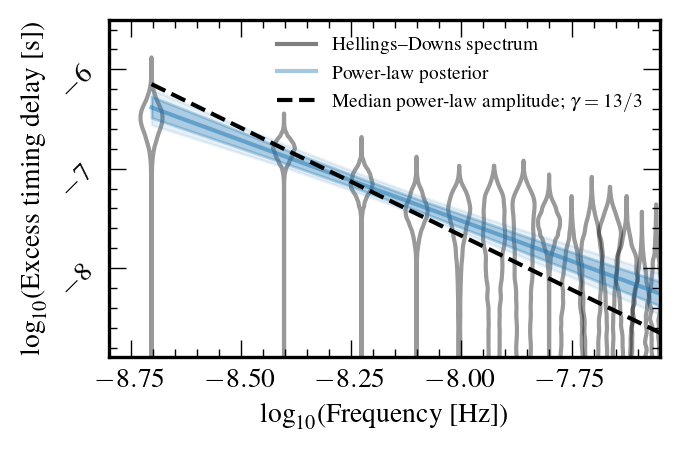

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, rasterized=True)

yrfac = np.log10(365.25 * 86400)
    
# free-spec violinplot of random samples
v2 = ax.violinplot(rv_samples_hd, positions=np.log10(freqs), 
                    widths=0.05, showextrema=False)

for pc in v2['bodies']:
    pc.set_facecolor('None')
    pc.set_edgecolor('k')
    pc.set_linestyle('solid')
    pc.set_alpha(0.4)
    pc.set_linewidth(1.5)

# pl bayesogram
pl_draws = np.zeros((10000,len(freqs)))
rnd_inds = np.random.randint(0, hd_chain.shape[0], size=10000)
for kk,jj in enumerate(rnd_inds):
    pl_draws[kk,:] = powerlaw(f=np.repeat(freqs,2), 
                                      log10_A=hd_chain[jj,1], gamma=hd_chain[jj,0])[::2]
pl_68top = np.array([np.percentile(pl_draws[:,ii],q=84) 
                      for ii in range(pl_draws.shape[1])])
pl_68bot = np.array([np.percentile(pl_draws[:,ii],q=16) 
                      for ii in range(pl_draws.shape[1])])
pl_90top = np.array([np.percentile(pl_draws[:,ii],q=95) 
                      for ii in range(pl_draws.shape[1])])
pl_90bot = np.array([np.percentile(pl_draws[:,ii],q=5) 
                      for ii in range(pl_draws.shape[1])])
pl_med = np.array([np.percentile(pl_draws[:,ii],q=50) 
                    for ii in range(pl_draws.shape[1])])

ax.fill_between(np.log10(freqs),
                 0.5*np.log10(pl_90top),0.5*np.log10(pl_90bot),
                 alpha=0.1,color='C0')
ax.fill_between(np.log10(freqs),
                 0.5*np.log10(pl_68top),0.5*np.log10(pl_68bot),
                 alpha=0.3,color='C0')
ax.plot(np.log10(freqs),
         0.5*np.log10(pl_med),color='C0', alpha=0.5)


fg_spec = 2.4e-15 * (freqs * 365.25*86400)**(-2./3.)
fg_spec = fg_spec**2 / 12. / np.pi**2 / freqs**3 / Tspan
ax.plot(np.log10(freqs),
         0.5*np.log10(fg_spec),color='k',ls='dashed',alpha=1.0)


# axis labels
ax.set_xlabel(r'$\log_{10}$(Frequency [Hz])'), 
           #fontsize=12)
ax.set_ylabel(r'$\log_{10}$(Excess timing delay [s])'), 
           #fontsize=12);

# legend
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

fs_hd = mlines.Line2D([], [], color='k', linestyle='solid', 
                      label='Hellings--Downs spectrum', alpha=0.5)
bplp = mlines.Line2D([], [], color='C0', 
                     label='Power-law posterior', alpha=0.4)
plp = mlines.Line2D([], [], color='k', 
                    label='Median power-law amplitude; $\gamma=13/3$', 
                    ls='dashed', alpha=1.0)
ax.legend(handles=[fs_hd, bplp, plp],
          loc='upper right',frameon=False)

plt.yticks(rotation=45)
ax.minorticks_on()
ax.tick_params(which='both',direction='in',
               tick2On=True)

ax.set_ylim(-8.9,-5.5)
ax.set_xlim(-8.8,-7.55)

plt.show()
#plt.savefig('nano15_hd_freespec_fig1_032223.pdf',bbox_inches='tight',dpi=400)